In [1]:
import keras
from keras import layers
from tensorflow import nn
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from os.path import exists

# MNIST Dataset

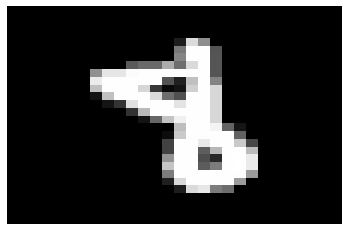

(28, 28, 1)

In [2]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

plt.pcolor( x_train[np.random.randint(ndata_train),::-1,:] , cmap = 'gray' )
plt.axis('off')
plt.show()

x_train = x_train.reshape((ndata_train,28,28,1))
x_test = x_test.reshape((ndata_test,28,28,1))
xshape = x_train.shape[1:]
xshape

# Autoencoders

In [3]:
embedding_shape = 50

In [4]:
input_img = keras.Input(shape=xshape)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(100,activation='relu')(x)
x = layers.Dense(80,activation='relu')(x)
x = layers.Dense(64,activation='relu')(x)
encoded = layers.Dense(embedding_shape,activation='sigmoid')(x)

x = layers.Dense(64,activation='relu')(encoded)
x = layers.Dense(80,activation='relu')(x)
x = layers.Dense(100,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(392,activation='relu')(x)
x = layers.Reshape((7, 7, 8))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [5]:
if not exists('./model_weights/autoencoder/autoencoder_model.index'):
    print("Training model")
    ae_callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=0.0005,
        restore_best_weights=True,
        verbose=1
    )
    autoencoder.fit(x_train,x_train,epochs=50,validation_split=0.2,batch_size=256, verbose=1, shuffle=True, callbacks=[ae_callback])
    autoencoder.save_weights('./model_weights/autoencoder/autoencoder_model')
else:
    print("Loading model")
    autoencoder.load_weights('./model_weights/autoencoder/autoencoder_model')

Loading model


313/313 [==============================] - 2s 2ms/step


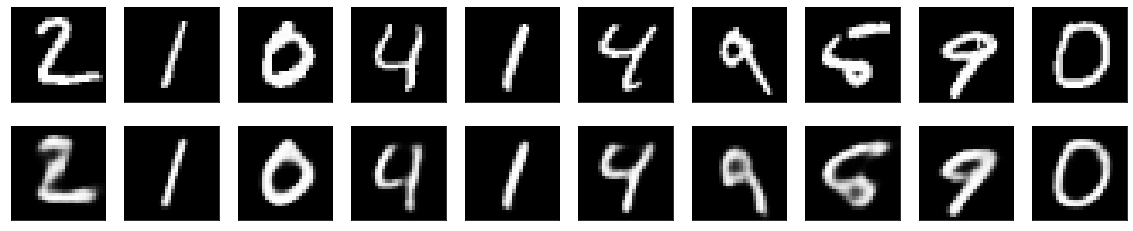

In [6]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
idx = np.random.randint(x_test.shape[0])

In [8]:
encoder = keras.Model(input_img, encoded)
encoded_op = encoder.predict(x_test[idx:idx+1])
display(y_test[idx])
encoded_op

1/1 [==============================] - 0s 106ms/step


1

array([[0.48494905, 0.13008761, 0.7595014 , 0.41827664, 0.36394754,
        0.07493984, 0.57358116, 0.5252452 , 0.03026726, 0.3184195 ,
        0.6637031 , 0.01709539, 0.5547777 , 0.75020397, 0.9287551 ,
        0.69755435, 0.2973771 , 0.7089731 , 0.3653343 , 0.5817397 ,
        0.07840388, 0.38368684, 0.23674218, 0.605418  , 0.4399961 ,
        0.44474822, 0.38632795, 0.99180037, 0.04420195, 0.8405984 ,
        0.6250735 , 0.50136644, 0.49827504, 0.18776414, 0.7011591 ,
        0.4411143 , 0.8741153 , 0.5147026 , 0.19746642, 0.47177824,
        0.02673137, 0.26059523, 0.63896245, 0.5796332 , 0.17804798,
        0.9518764 , 0.55145735, 0.30916798, 0.27956167, 0.9988612 ]],
      dtype=float32)

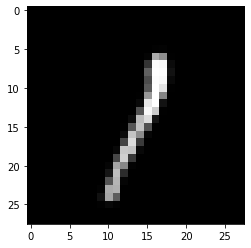

In [9]:
reprentn = encoded_op

decoder = keras.Model(encoded, decoded)
plt.imshow(
    decoder(reprentn + 0.5*np.random.random()).numpy().reshape((28, 28))
)

# Neural Net

In [10]:
ip_classifier = keras.Input(shape=xshape)

x = layers.Conv2D(filters=32,kernel_size=(3,3),padding="same")(ip_classifier)
x = layers.MaxPooling2D(pool_size=(3,3), strides=1)(x)
x = layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(4,4), strides=2)(x)
x = layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(4,4), strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(100,activation='relu')(x)
x = layers.Dense(80,activation='relu')(x)
x = layers.Dense(60,activation='relu')(x)
x = layers.Dense(40,activation='relu')(x)
x = layers.Dense(20,activation='relu')(x)
op_classifier = layers.Dense(10,activation='softmax')(x)

classifier_model = keras.Model(ip_classifier, op_classifier)
classifier_model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

classifier_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 9, 9, 128)         7385

In [11]:
if not exists('./model_weights/neural-net/classifier_model.index'):
    print("Training model")
    cl_callback = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.0002,
        restore_best_weights=True,
        verbose=1
    )
    classifier_model.fit(x_train,y_train,epochs=50,validation_split=0.2,batch_size=128, verbose=1, shuffle=True, callbacks=[cl_callback])
    classifier_model.save_weights('./model_weights/neural-net/classifier_model')
else:
    print("Loading model")
    classifier_model.load_weights('./model_weights/neural-net/classifier_model')

Loading model


In [12]:
pred_probs = classifier_model.predict(x_test)
pred2 = np.argmax(pred_probs, axis=1)
print(np.mean(pred2==y_test))

313/313 [==============================] - 1s 2ms/step
0.9913


# AutoEncoder + Neural network

In [13]:
autoencoder.trainable = False

ip_aeclassifier = keras.Input(shape=xshape)
x = autoencoder(ip_aeclassifier, training=False)
x = layers.Conv2D(filters=32,kernel_size=(3,3),padding="same")(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=1)(x)
x = layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(4,4), strides=2)(x)
x = layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(4,4), strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(100,activation='relu')(x)
x = layers.Dense(80,activation='relu')(x)
x = layers.Dense(60,activation='relu')(x)
x = layers.Dense(40,activation='relu')(x)
x = layers.Dense(20,activation='relu')(x)
op_aeclassifier = layers.Dense(10,activation='softmax')(x)

aeclassifier_model = keras.Model(ip_aeclassifier, op_aeclassifier)
aeclassifier_model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

aeclassifier_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         164163    
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                       

In [14]:
if not exists('./model_weights/ae-nn/aeclassifier_model.index'):
    print("Training model")
    cl_callback = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.0002,
        restore_best_weights=True,
        verbose=1
    )
    aeclassifier_model.fit(x_train,y_train,epochs=50,validation_split=0.2,batch_size=128, verbose=1, shuffle=True, callbacks=[cl_callback])
    aeclassifier_model.save_weights('./model_weights/ae-nn/aeclassifier_model')
else:
    print("Loading model")
    aeclassifier_model.load_weights('./model_weights/ae-nn/aeclassifier_model')

Loading model


In [15]:
pred_probs = aeclassifier_model.predict(x_test)
pred2 = np.argmax(pred_probs, axis=1)
print(np.mean(pred2==y_test))

313/313 [==============================] - 1s 2ms/step
0.9606


# Adversarial image

https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

In [16]:
from tensorflow import GradientTape, sign
import tensorflow as tf

In [17]:
loss_object = keras.losses.CategoricalCrossentropy()

def get_adversarial_label(prediction, input_label):
    pred_copy = prediction.numpy()[0]
    pred_copy[input_label] = -1
    return np.argmax(pred_copy)

def create_adversarial_pattern(input_image, input_label, directed=False):
    # x -> [x]
    input_image = tf.convert_to_tensor(input_image[None, ...], dtype=None, dtype_hint=None, name=None)

    # Gradient
    with GradientTape() as tape:
        tape.watch(input_image)
        prediction = classifier_model(input_image)
        if directed:
            input_label = get_adversarial_label(prediction, input_label)
        # y1 -> [[0,1,0,...0]]
        input_label = tf.one_hot(input_label, 10)
        input_label = tf.reshape(input_label, (1, 10))
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    direction = -1 if directed else 1
    gradient = tape.gradient(loss, input_image)
    signed_grad = (direction*gradient)[0]
    return ((signed_grad - signed_grad.numpy().mean())/(signed_grad.numpy().max() - signed_grad.numpy().min() + 10**(-10)))

def get_adversarial_image(input_image, input_label, epsilon=0.01, directed=False):
    noise = create_adversarial_pattern(input_image, input_label, directed=directed)
    adv_x = input_image + epsilon*noise
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    return adv_x.numpy(), noise.numpy()

In [18]:
rnd_numb = np.random.randint(y_test.shape[0])
test_label = y_test[rnd_numb]
test_image = x_test[rnd_numb]

grad = create_adversarial_pattern(test_image, test_label)
import pandas as pd
pd.Series(grad.numpy().reshape((28*28,))).describe()

count    7.840000e+02
mean     3.229124e-08
std      7.628558e-07
min     -4.744475e-06
25%     -3.638284e-08
50%      0.000000e+00
75%      6.488976e-08
max      7.733064e-06
dtype: float64

In [ ]:
def demo_adversarial_attack(input_image, input_label, epsilon=0.01, directed=False):
    adv_img, noise = get_adversarial_image(input_image, input_label, epsilon=epsilon, directed=directed)

    actual_label = input_label

    # Neural network prediction of the original image
    pred = classifier_model(input_image[None, ...]).numpy().reshape((10,))
    original_prediction_conf = pred.max().round(5)
    original_prediction = pred.argmax()

    # Neural network prediction of the adversarial image
    adv_x = adv_img.reshape((1,*adv_img.shape))
    pred = classifier_model(adv_x).numpy().reshape((10,))
    adv_prediction_conf = pred.max().round(5)
    adv_prediction = pred.argmax()

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(18)

    print(f"Actual Label of the Image: {actual_label}")
    
    ax0.pcolor(input_image.reshape((28,28))[::-1], cmap='gray')
    ax0.axis('off')
    ax0.set_title(f"Original Image\nPrediction: {original_prediction}\nConfidence of prediction: {original_prediction_conf}")

    ax1.pcolor(noise.reshape((28,28))[::-1], cmap='gray')
    ax1.axis('off')
    ax1.set_title("Perturbations being added")

    ax2.pcolor(adv_img.reshape((28,28))[::-1], cmap='gray')
    ax2.axis('off')
    ax2.set_title(f"Adversarial Image\nPrediction: {adv_prediction}\nConfidence of prediction: {adv_prediction_conf}")

In [ ]:
rnd_numb = np.random.randint(y_test.shape[0])
test_label = y_test[rnd_numb]
test_image = x_test[rnd_numb]

demo_adversarial_attack(test_image, test_label, epsilon=0.1, directed=True)

In [ ]:
def predict_adversarial_labels(input_images, input_labels, epsilon=0.01, directed=False):
    n_len = len(input_images)
    ret_labels = np.zeros(n_len)
    for i in range(n_len):
        adv_img, _ = get_adversarial_image(input_images[i], input_labels[i], epsilon=epsilon, directed=directed)
        # if i%1000 == 13:
        #     plt.pcolor(adv_img.reshape((28,28))[::-1], cmap='gray')
        #     plt.show()
        adv_x = adv_img.reshape((1,*adv_img.shape))
        pred = classifier_model(adv_x).numpy().reshape((10,))
        ret_labels[i] = pred.argmax()
    return ret_labels

In [ ]:
adversarial_labels = predict_adversarial_labels(x_test, y_test, epsilon=0.9, directed=False)
print(np.mean(adversarial_labels==y_test))

In [ ]:
aeclassifier_model